# Rotten Tomatoes Freshness Analyzer

**Progetto d'Esame**

**Corso di Programmazione di Applicazioni Data Intensive**

Laurea in Ingegneria e Scienze Informatiche  

DISI - Università di Bologna, Cesena

Studenti:
- Luca Giuliani, 0000792513, luca.giuliani10@studio.unibo.it
- Filippo Pilutti, 0000793420, filippo.pilutti@studio.unibo.it

## 0. Introduzione

Lo scopo dell'applicazione è di stabilire se, data la recensione di un film presente nel sito **Rotten Tomatoes**, tale recensione è **fresh** o **rotten**, ovvero se il film è considerato o meno positivo da chi ha scritto la recensione.
Per il training del sistema si è utilizzato un dataset di recensioni reperito da **Kaggle** al seguente link:

https://www.kaggle.com/rpnuser8182/rotten-tomatoes

### Setup Librerie
Durante il progetto, si farà largo uso delle seguenti librerie:
- **NumPy**, per l'utilizzo di vettori e matrici e le relative operazioni matematiche
- **Pandas**, per la struttura dei dati tabulari sotto forma di dataframe facilmente accessibili e comprensibili
- **Matplotlib**, per la visualizzazione sotto forma di grafico delle caratteristiche del dataset
- **Ntlk**, per l'elaborazione dei dati in linguaggio naturale dei testi delle canzoni

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

## 1/2. Analisi Dataset e Standardizzazione

### Importazione

Nel caso il dataset non fosse presente, è possibile scaricarlo direttamente da kaggle mettendo le proprie credenziali e facendo uso del modulo 'kaggle' che contiene delle API per il download automatico dei dati.
Il modulo può essere installato con il comando: `pip install kaggle --upgrade`

In [2]:
import os.path
if not os.path.exists('reviews.tsv'):
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('rpnuser8182/rotten-tomatoes', unzip=True)
original_dataset = pd.read_csv('reviews.tsv', sep='\t', encoding = 'unicode_escape')

### Descrizione dei Dati

In [3]:
original_dataset.shape

(54432, 8)

In [4]:
pd.concat([original_dataset.head(5), original_dataset.tail(5)])

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"
54431,2000,NaN,3/5,fresh,Nicolas Lacroix,0,Showbizz.net,"November 12, 2002"


Il **dataset** è popolato con **54432 recensioni** di film prese dal sito **Rotten Tomatoes**.

Dato che è possibile che alcune siano ripetute, viene tenuta una sola istanza per ognuna di esse.

In [5]:
original_dataset.drop_duplicates(keep = 'first', inplace = True)
original_dataset.shape

(54423, 8)

Rimangono **54423 recensioni**, ognuna delle quali contiene informazioni memorizzate in **8 colonne**:
1. **id**, ovvero l'identificatore del film (i dati del film sono infatti mantenuti in un'altro dataset)
2. **review**, ovvero la recensione del film
3. **rating**, ovvero un voto della recensione, che tuttavia è espresso in scale non standardizzate e, spesso, non è nemmeno presente, rendendo di fatto questa colonna inutile per il sistema di regressione
4. **fresh**, ovvero se il film è complessivamente positivo o meno
5. **critic**, ovvero il nome del critico
6. **top critic**, ovvero se il critico è considerato top critic di Rotten Tomatoes
7. **publisher**, ovvero chi ha pubblicato la recensione
8. **date**, ovvero la data della recension

Per quanto riguarda lo scopo del nostro sistema, le colonne importanti sono la 2 (**reviews**), ovvero la variabile da analizzare, e la 4 (**fresh**), ovvero la variabile da predire.

### Estrazione Feature Utili

Per prima cosa, è necessario creare un **nuovo dataset**, sottoinsieme del precedente, che contenga soltanto le colonne utili, e scartiamo innanzitutto i valori **nan** di entrambe le colonne.

In [6]:
dataset = original_dataset[['review', 'fresh']].dropna().astype({'review' : 'object', 'fresh' : 'object'})
pd.concat([dataset.head(5), dataset.tail(5)])

,review,fresh
0,A distinctly gallows take on contemporary fina...,fresh
1,It's an allegory in search of a meaning that n...,rotten
2,... life lived in a bubble in financial dealin...,fresh
3,Continuing along a line introduced in last yea...,fresh
4,... a perverse twist on neorealism...,fresh
54423,"Despite the title, Wasabi isn't so spicy.",rotten
54424,Dawdles and drags when it should pop; it doesn...,rotten
54425,Despite Besson's high-profile name being Wasab...,fresh
54426,The film lapses too often into sugary sentimen...,rotten
54427,The real charm of this trifle is the deadpan c...,fresh


### Analisi Esplorativa

A questo punto, descriviamo i **dati principali** del dataset ottenuto.

In [7]:
dataset.describe()

,review,fresh
count,48867,48867
unique,48682,2
top,Parental Content Review,fresh
freq,24,29875


Facciamo poi un'**analisi delle variabili** necessarie per il training e il testing del sistema, in modo da capire se alcuni dati vanno scartati perché non disponibili e/o corrotti.

#### Analisi Giudizi

In [8]:
dataset['fresh'].value_counts(normalize = 'True') * 100

fresh     61.135326
rotten    38.864674
Name: fresh, dtype: float64

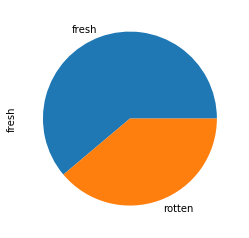

In [9]:
dataset['fresh'].value_counts().plot.pie()

La maggior parte delle recensioni sono **positive**, cosa di cui bisognerà tenere conto nel momento in cui si va a validare il modello ottenuto.

#### Analisi Recensioni

Come visto tramite l'analisi dei dati, alcune recensioni non contengono altro che la frase **Parental Content Review**. Risulta ammissibile, inoltre, che ci siano altre recensioni non significative, pertanto queste vanno cercate ed eliminate.

In [10]:
values = dataset['review'].value_counts()
values[values > 2]

Parental Content Review                 24
full review at Movies for the Masses    15
full review in Greek                     9
Click to read review                     3
click to read the full review            3
Name: review, dtype: int64

Dato che non contengono informazioni utili, queste recensioni andranno eliminate.

In [11]:
dataset.drop_duplicates(subset = ['review'], keep = False, inplace = True)
dataset.shape

(48541, 2)

#### Dataset Finale

Prima di costruire il dataset finale, effettuiamo un **reindexing** dei dati per comodità.

In [12]:
dataset.index = np.arange(0, dataset.index.size)
pd.concat([dataset.head(5), dataset.tail(5)])

,review,fresh
0,A distinctly gallows take on contemporary fina...,fresh
1,It's an allegory in search of a meaning that n...,rotten
2,... life lived in a bubble in financial dealin...,fresh
3,Continuing along a line introduced in last yea...,fresh
4,... a perverse twist on neorealism...,fresh
48536,"Despite the title, Wasabi isn't so spicy.",rotten
48537,Dawdles and drags when it should pop; it doesn...,rotten
48538,Despite Besson's high-profile name being Wasab...,fresh
48539,The film lapses too often into sugary sentimen...,rotten
48540,The real charm of this trifle is the deadpan c...,fresh


Mappiamo infine la colonna **fresh** in una colonna booleana: quella sarà la variabile numerica da prevedere.

In [13]:
dataset['fresh'] = dataset['fresh'] == 'fresh'
dataset['fresh'].dtype

dtype('bool')

Il **dataset finale** sarà quindi così strutturato:

In [14]:
pd.concat([dataset.head(5), dataset.tail(5)])

,review,fresh
0,A distinctly gallows take on contemporary fina...,True
1,It's an allegory in search of a meaning that n...,False
2,... life lived in a bubble in financial dealin...,True
3,Continuing along a line introduced in last yea...,True
4,... a perverse twist on neorealism...,True
48536,"Despite the title, Wasabi isn't so spicy.",False
48537,Dawdles and drags when it should pop; it doesn...,False
48538,Despite Besson's high-profile name being Wasab...,True
48539,The film lapses too often into sugary sentimen...,False
48540,The real charm of this trifle is the deadpan c...,True


Ed avrà le seguenti caratteristiche:

In [15]:
dataset.shape

(48541, 2)

In [16]:
dataset.describe()

,review,fresh
count,48541,48541
unique,48541,2
top,"Thunderball, the biggest, most lavish, and lon...",True
freq,1,29738


## 3/4. Generazione e Validazione di Modelli Differenti

### Divisione in Traning Set e Test Set

Come da pratica generale, il **test set** corrisponde al 30% dell'intero data set, mentre il 70% viene lasciato per il **training**.

In [17]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(dataset, test_size = 0.3, random_state = 0)

In [18]:
trainset.head()

,review,fresh
26829,"A sprawling, melancholy epic anti-Western.",True
31370,The script for this comedy is so half-baked th...,False
15670,A bold and rousing historical epic.,True
21106,Russell is obviously working out his considera...,False
5188,"The result is a film that lacks the coherence,...",False


In [19]:
testset.head()

,review,fresh
36388,It is like Winnie the Pooh: it might be of Ver...,True
26974,The story's strong point isn't psychological d...,True
12789,"Chappaquiddick"" is exactly what you want it to...",True
7999,"Life, death, the beyond... Ah, the beyond. Suc...",False
8668,"The story bungles ahead pointlessly, mixing me...",False


### Importazione Features

Come prima cosa bisogna importare le **features** necessarie dalla libreria **sklearn**:

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()
pos_dictionary = {'N': 'n', 'V': 'v', 'J': 'a', 'R': 'r'}

def tokenize(sentence):
    return [lemmatizer.lemmatize(word, pos_dictionary.get(pos[0], 'a'))
            for word, pos in
            nltk.pos_tag(list(filter(lambda s: s not in stopwords,
                                     list(map(lambda s: s.lower(),
                                              nltk.tokenize.word_tokenize(sentence))))))]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Luke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Luke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Scelta del Modello

A questo punto non rimane che **scegliere il modello migliore** e addestrarlo.

Per fare ciò, si sono susseguite delle **iterazioni** utili alla scelta degli **iperparametri** e degli **algoritmi da utilizzare**.

Di seguito sono quindi elencati i passaggi eseguiti durante le varie iterazioni, le quali hanno generato modelli con **score differenti** e tra i quali è stato possibile scegliere il migliore dopo aver identificato dei trend che indicavano il settaggio più adeguato.

Il **punteggio** ottenuto dai vari modelli è stato calcolato, in ogni iterazione, tramite il seguente validatore:

In [21]:
validator = KFold(n_splits = 10)

Il quale è stato passato, insieme al **modello** e alla **griglia**, come parametro dell'oggetto *GridSearchCV*

#### Prima Iterazione

Inizialmente, si è utilizzato un **CountVectorizer** e un classificatore di tipo **LogisticRegression** utilizzante l'algoritmo **liblinear**:

In [22]:
first_model = model = Pipeline([
    ('vectorizer', CountVectorizer(stop_words = 'english')),
    ('classifier', LogisticRegression(solver = 'liblinear'))
])

La griglia di iperparametri è stata impostata come segue:

In [23]:
first_grid = {
    'vectorizer__min_df': [1, 3, 10],
    'vectorizer__max_df': [0.8, 0.9, 1.0],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-2, 2, 3)
}

Riasumendo, questi sono i risultati ottenuti:
- **miglior configurazione**: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
- **score**: 0.7720
- **dettagli sulle altre configurazioni**: in tutte le configurazioni migliori, il valore di C era 1.0 e la penalty di tipo l2, mentre né l'utilizzo di ngram né un basso max_df hanno influito particolarmente, per cui si è scelta la configurazione (1, 1) e 0.8 perché più veloce; al contrario, con un basso min_df lo score si è dimostrato notevolmente migliore

#### Seconda Iterazione

Utilizzando i dati precedentemente acquisiti, si è fatta un'analisi su **altri algormitmi**.

Il modello è rimasto lo stesso, ma griglia di iperparametri è stata costruita nel seguente modo:

In [24]:
second_grid = {
    'vectorizer__max_df': [0.8, 0.9, 1.0],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__C': np.logspace(-2, 2, 3)
}

I risultati ottenuti sono molto simili a quelli dell'iterazione precedente, e mostrano come i due algoritmi che permettono di ottenere una confidenza maggiore sono *newton-cg* e *liblinear*.
Per tentare di migliorare ulteriormente il modello, infine, sono stati aggiunti altri elementi quali un **Tfidf Vectorizer** con custom tokenization che tiene conto della **Part of Speech** e della **lemmatizzazione**.

#### Terza Iterazione

Nella terza iterazione, si sono introdotte ulteriori metodi sperando che lo score potesse aumentare.

A tale scopo, è stata usata anche la funzione *tokenize* precedentemente definita, allo scopo di considerare soltanto le parole utili.

Il modello utilizzato è stato quindi:

In [25]:
third_model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

Mentre la griglia di iperparametri su cui basare il modello è stata così costruita:

In [26]:
third_grid = {
    'vectorizer__tokenizer': [None, tokenize],
    'vectorizer__max_df': [0.8, 0.9],
    'classifier__solver': ['newton-cg', 'liblinear'],
    'classifier__C': np.logspace(-4, -4, 5)
}

Il **punteggio ottenuto** non si è rivelato soltanto di poco superiore a quello delle precedenti iterazioni.

Nel modello finale, tuttavia, si è scelto di usare un *TfidfVectorizer* perché, seppur non aumentando di troppo lo score, i punteggi assegnati alle parole sembrano adatti a qualsiasi tipo di recensione, mentre utilizzando il *CountVectorizer* alcune parole con punteggio estremamente alto/basso non sembravano avere significato generale ma soltanto nel dataset ottenuto.

#### Quarta Iterazione

Infine, si è tentato di cambiare modello di classificazione e utilizzare una **Support Vector Machine** per capire se, utiilizzando una separazione non lineare dei dati, si sarebbe potuto ottenere un risultato migliore.

Come modello dei dati, quindi, si è usato questo:

In [27]:
fourth_model = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = tokenize, max_df = 0.8)),
    ('classifier', SVC())
])

Mentre sono state provate le combinazioni di iperparametri presenti in questa griglia:

In [28]:
fourth_grid = {
    'classifier__solver': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'classifier__C': np.logspace(-2, -2, 3)
}

Il risultato ottenuto si è dimostrato in linea con quelli ottenuti in precedenza, con uno **score** che nei migliori casi si aggira intorno al **77%**, e ha favorito il kernel di tipo **linear**, dimostrando che difficilmente sarà possibile ottenere risultati migliori su questo dataset.

Come **modello finale dei dati**, pertanto, si è scelto di utilizzare quello ottenuto durante la terza iterazione.

## 5. Scelta del Modello Ottimo e Analisi del Risultato

### Modello Ottimo

Dalle tre iterazioni precedenti, il **modello ottimo** fra quelli indagati è risultato questo:

In [29]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = tokenize, max_df = 0.8)),
    ('classifier', LogisticRegression(C = 1.0, penalty = 'l2', solver = 'liblinear'))
])

A questo punto, è quindi possibile **addestrare il modello** sui dati di training:

In [30]:
model.fit(trainset['review'], trainset['fresh'])

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

Per poi **validarlo** sui dati di testing:

In [31]:
model.score(testset['review'], testset['fresh'])

0.772986335233125

Ottenendo uno score del **77.30%**

#### Analisi delle Probabilità

Creiamo un **checkset** che associa a ogni riga del testset il valore originale e quello predetto dal modello.

In [32]:
checkset = testset.rename(columns = {'fresh': 'actual'})
checkset['predicted'] = model.predict(testset['review'])
checkset['hyperplane distance'] = model.decision_function(testset['review'])

probs = model.predict_proba(testset['review'])
checkset['fresh probability'] = probs[:, 1]
checkset['rotten probability'] = probs[:, 0]

checkset.index = np.arange(0, checkset.index.size)
pd.concat([checkset.head(5), checkset.tail(5)])

,review,actual,predicted,hyperplane distance,fresh probability,rotten probability
0,It is like Winnie the Pooh: it might be of Ver...,True,True,0.804448,0.690925,0.309075
1,The story's strong point isn't psychological d...,True,False,-0.113371,0.471687,0.528313
2,"Chappaquiddick"" is exactly what you want it to...",True,True,0.787265,0.687244,0.312756
3,"Life, death, the beyond... Ah, the beyond. Suc...",False,True,0.996858,0.730440,0.269560
4,"The story bungles ahead pointlessly, mixing me...",False,False,-0.444620,0.390641,0.609359
14558,"This movie has no focus, no point of view and ...",False,False,-1.894391,0.130745,0.869255
14559,The only noticeable Resident Evil on display h...,False,False,-0.538831,0.368460,0.631540
14560,Instead of gently skewering the conventions of...,False,False,-0.465478,0.385687,0.614313
14561,Smith carries it off with his effortless charm...,True,True,0.958294,0.722780,0.277220
14562,"Cosmopolis may, like Packer's limo, be an elab...",True,True,1.002788,0.731606,0.268394


**Recensione con Maggior Probabilità Positiva**

In [33]:
row = checkset[checkset['fresh probability'] == [checkset['fresh probability'].max()]]
row.iloc[0]['review']

"Fincher's achievement is, in both quality and spirit, a film of great beauty, and it touched me deeply."

In [34]:
row[['actual', 'predicted', 'hyperplane distance', 'fresh probability', 'rotten probability']]

,actual,predicted,hyperplane distance,fresh probability,rotten probability
8542,True,True,5.427516,0.995625,0.004375


**Recensione con Maggior Probabilità Negativa**

In [35]:
row = checkset[checkset['rotten probability'] == [checkset['rotten probability'].max()]]
row.iloc[0]['review']

"You wouldn't think a movie with this much plot could be this dull, but you'd be wrong."

In [36]:
row[['actual', 'predicted', 'hyperplane distance', 'fresh probability', 'rotten probability']]

,actual,predicted,hyperplane distance,fresh probability,rotten probability
11289,False,False,-4.89482,0.00743,0.99257


#### Matrice di Confusione

Di seguito viene mostrata la **matrice di confusione** del modello ottenuto e i vari valori interessanti ricavabili da essa.

In [37]:
tp = checkset[(checkset['actual'] == True) & (checkset['predicted'] == True)]
tn = checkset[(checkset['actual'] == False) & (checkset['predicted'] == False)]
fp = checkset[(checkset['actual'] == False) & (checkset['predicted'] == True)]
fn = checkset[(checkset['actual'] == True) & (checkset['predicted'] == False)]

tps = tp.index.size
tns = tn.index.size
fps = fp.index.size
fns = fn.index.size

pd.DataFrame(data = { 'Predicted Fresh' : [tps, fps], 'Predicted Rotten' : [fns, tns] },
             index = ['Actual Fresh', 'Actual Rotten'])

,Predicted Fresh,Predicted Rotten
Actual Fresh,7832,1102
Actual Rotten,2204,3425


**Accuracy**

In [38]:
(tps + tns) / (tps + tns + fps + fns)

0.772986335233125

**Precision & Recall**

In [39]:
precision_fresh = tps / (tps + fps)
precision_fresh

0.7803905938620964

In [40]:
precision_rotten = tns / (tns + fns)
precision_rotten

0.7565716810249613

In [41]:
recall_fresh = tps / (tps + fns)
recall_fresh

0.8766509961943139

In [42]:
recall_rotten = tns / (tns + fps)
recall_rotten

0.6084562089181027

**F1 Measures**

In [43]:
f1_fresh = (2 * precision_fresh * recall_fresh) / (precision_fresh + recall_fresh)
f1_fresh

0.825724828676858

In [44]:
f1_rotten = (2 * precision_rotten * recall_rotten) / (precision_rotten + recall_rotten)
f1_rotten

0.6744781410003937

#### Esempi di Previsioni Errate

Al fine di indagare le cause delle previsioni errate, si mostrano **due esempi**, rispettivamente con errore più basso e più alto nelle probabiltà, di falsi positivi (recensioni etichettate come *fresh* che sono invece *rotten*) e di falsi negativi (recensioni etichettate come *rotten* che sono invece *fresh*).

**Falsi Positivi**

In [45]:
fp.describe()

,hyperplane distance,fresh probability,rotten probability
count,2204.000000,2204.000000,2204.000000
mean,0.681288,0.652479,0.347521
std,0.547532,0.106123,0.106123
min,0.000258,0.500064,0.033481
25%,0.257508,0.564024,0.276237
50%,0.552950,0.634820,0.365180
75%,0.963206,0.723763,0.435976
max,3.362719,0.966519,0.499936


*Recensione con Errore Maggiore*

In [46]:
fp_highest_error = fp[fp['fresh probability'] == [fp['fresh probability'].max()]]
fp_highest_error.iloc[0]['review']

'It demands love, which is the best way not to get it.'

In [47]:
fp_highest_error[['actual', 'predicted', 'hyperplane distance', 'fresh probability', 'rotten probability']]

,actual,predicted,hyperplane distance,fresh probability,rotten probability
12531,False,True,3.362719,0.966519,0.033481


*Recensione con Errore Minore*

In [48]:
fp_lowest_error = fp[fp['fresh probability'] == [fp['fresh probability'].min()]]
fp_lowest_error.iloc[0]['review']

"Paul Weitz's American Dreamz assembles a sumptuous buffet for the viewer, but since Weitz isn't hungry, he just stares at the spread, dumbly refusing to eat when really he should gorge."

In [49]:
fp_lowest_error[['actual', 'predicted', 'hyperplane distance', 'fresh probability', 'rotten probability']]

,actual,predicted,hyperplane distance,fresh probability,rotten probability
7698,False,True,0.000258,0.500064,0.499936


**Falsi Negativi**

In [50]:
fn.describe()

,hyperplane distance,fresh probability,rotten probability
count,1102.000000,1102.000000,1102.000000
mean,-0.556208,0.373465,0.626535
std,0.501559,0.099603,0.099603
min,-3.363231,0.033465,0.500121
25%,-0.776936,0.314981,0.547921
50%,-0.419072,0.396739,0.603261
75%,-0.192273,0.452079,0.685019
max,-0.000486,0.499879,0.966535


*Recensione con Errore Maggiore*

In [51]:
fn_highest_error = fn[fn['rotten probability'] == [fn['rotten probability'].max()]]
fn_highest_error.iloc[0]['review']

'Depp and Jolie lack sparks, but The Tourist is a light little lark of a mystery-love story.'

In [52]:
fn_highest_error[['actual', 'predicted', 'hyperplane distance', 'fresh probability', 'rotten probability']]

,actual,predicted,hyperplane distance,fresh probability,rotten probability
9948,True,False,-3.363231,0.033465,0.966535


*Recensione con Errore Minore*

In [53]:
fn_lowest_error = fn[fn['rotten probability'] == [fn['rotten probability'].min()]]
fn_lowest_error.iloc[0]['review']

'There are no wasted moments here. There are no wasted characters. The film is as much about Martin Luther King Jr. as it is about the people he worked with, and fought for.'

In [54]:
fn_lowest_error[['actual', 'predicted', 'hyperplane distance', 'fresh probability', 'rotten probability']]

,actual,predicted,hyperplane distance,fresh probability,rotten probability
12293,True,False,-0.000486,0.499879,0.500121


**Considerazioni**

Risulta chiaro che le recensioni etichettate in maniera errata sono perlopiù ambigue e/o contengono termini positivi negati (o viceversa), che il modello non riesce ad interpretare nel complesso.

#### Parole Con Coefficienti Più Alti

In ultimo, vengono mostrate due liste di parole con i relativi coefficienti il cui peso incide sul valore positivo (*fresh*) o negativo (*rotten*) della recensione in base al segno del coefficiente stesso.

In [55]:
logistic_regression = model.named_steps['classifier']
count_vectorizer = model.named_steps['vectorizer']
coefs = pd.Series(logistic_regression.coef_[0], index = count_vectorizer.get_feature_names())
coefs.sort_values(inplace = True)

**Parole a Maggiore Incidenza Negativa**

In [56]:
coefs.head(10)

lack            -4.110912
unfortunately   -4.108123
fail            -4.099627
tedious         -4.099480
bland           -3.871457
dull            -3.852082
bad             -3.742408
misfire         -3.595049
fails           -3.464217
mess            -3.406680
dtype: float64

**Parole a Maggiore Incidenza Positiva**

In [57]:
coefs.tail(10)

masterpiece    2.854368
classic        2.867702
rare           2.904831
best           3.031230
performance    3.036795
entertain      3.133429
powerful       3.184236
perfect        3.266599
enjoyable      3.432693
fun            3.652566
dtype: float64

**Considerazioni**

Come già spiegato durante il paragrafo sulla scelta del modello, si è preferito usare un *TfidVectorizer* piuttosto che un *CountVectorizer* proprio perché il primo ha prodotto una lista di parole a incidenza positiva/negativa coerenti con il linguaggio naturale, mentre il secondo ha prodotto anche parole che avrebbero permesso un ottimo score su questo dataset ma che non avevano alcuna incidenza positiva/negativa nel linguaggio naturale, quali ad esempio dei nomi propri di persone o città. 